# APMTH 207: Advanced Scientific Computing: 
## Stochastic Methods for Data Analysis, Inference and Optimization
## Homework #6
**Harvard University**<br>
**Spring 2017**<br>
**Instructors: Rahul Dave**<br>
**Due Date: ** Thursday, March 9th, 2017 at 11:59pm

**Instructions:**

- Upload your final answers as well as your iPython notebook containing all work to Canvas.

- Structure your notebook and your work to maximize readability.

## Problem 1: Gibbs Sampling

Let $\mathbf{X}$ be a random variable taking values in $\mathbb{R}^2$. That is, $\mathbf{X}$ is a 2-dimensional vector. Suppose that $\mathbf{X}$ is normally distributed as follows
$$ 
\mathbf{X} \sim \mathcal{N} \left(  
\left[
\begin{array}{c}
    1  \\ 
    2  \\ 
  \end{array} 
\right],
\left[
  \begin{array}{ccc}
    4 & 1.2  \\ 
    1.2 & 4 \\ 
  \end{array} 
  \right] \right).
$$ 
That is, the pdf of the distribution of $\mathbf{X}$ is
$$
f_{\mathbf{X}}(\mathbf{x}) = \frac{1}{2\pi\sqrt{\vert \Sigma\vert }}\mathrm{exp}\left\{ - \frac{1}{2} (\mathbf{x} - \mu)^\top \Sigma^{-1} (\mathbf{x} - \mu)\right\}
$$
where $\mu = \left[
\begin{array}{c}
    1  \\ 
    2  \\ 
  \end{array} 
\right]$, $\Sigma = \left[
  \begin{array}{ccc}
    4 & 1.2  \\ 
    1.2 & 4 \\ 
  \end{array} 
  \right]$, and $\vert \cdot\vert $ is the matrix determinant operator.

In the following, we will denote the random variable corresponding to the first component of $\mathbf{X}$ by $X_1$ and the second component by $X_2$.

### Part A:
Write the Gibbs sampler for this distribution by sampling sequentially from the two conditional distributions $f_{X_1\vert X_2}, f_{X_2\vert X_1}$. Choose a thinning parameter, burn-in factor and total number of iterations that allow you to take 10000 non-autocorrelated draws. You must justify your choice of parameters. 

Implement the functions for the pdf of the distribution while holding each component constant:

In [1]:
%matplotlib inline
import numpy as np
import scipy.stats as sps
from scipy import stats
from scipy.stats import norm, gamma, multivariate_normal
from scipy.stats import distributions
import matplotlib.pyplot as plt
import seaborn as sns
import time
sns.set_style('whitegrid')
sns.set_context('poster')
import warnings
warnings.filterwarnings('ignore')

# use the provided bi-variate normal pdf.
def func(x1s,x2s):
    r_var = multivariate_normal(mean=[1,2],cov=[[4,1.2],[1.2,4]])
    return r_var.pdf(np.array([x1s,x2s]).T)

# get a random draw from x1 conditional dist. while holding x2 constant.
def x1cond(x2):
    mean = 1 + (1.2*(.25)*(x2-2))
    std = 4 -(1.2*.25*1.2)
    return norm(mean,std).rvs()

# get a random draw from x2 conditional dist. while holding x1 constant.
def x2cond(x1): 
    mean = 2 + (1.2*(.25)*(x1-1))
    std = 4 -(1.2*.25*1.2)
    return norm(mean,std).rvs()

# Plot the shape of our Distribution

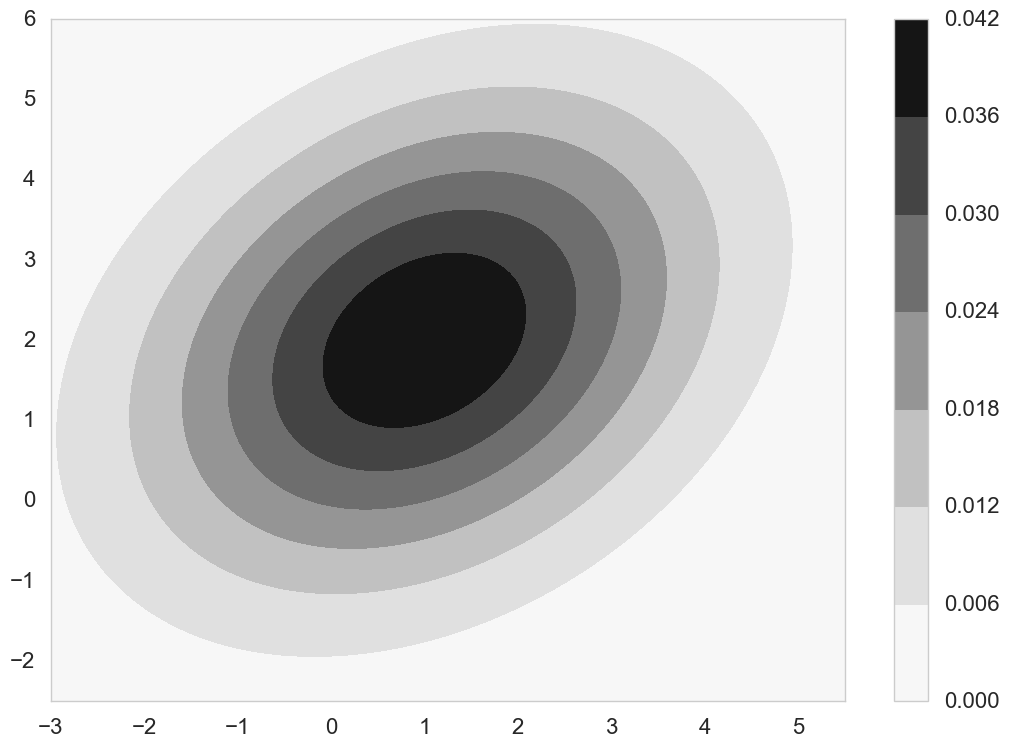

In [2]:
numgridpoints=400
x = np.linspace(-3,5.5,numgridpoints)
y = np.linspace(-2.5,6,numgridpoints)
xx,yy = np.meshgrid(x,y)
zz = np.zeros((numgridpoints,numgridpoints))
for i in np.arange(0,numgridpoints):
    for j in np.arange(0,numgridpoints):
        zz[i,j]=func(xx[i,j],yy[i,j])
        
cp = plt.contourf(xx,yy,zz);
plt.colorbar(cp)

In [3]:
# A function to generate samples using the Gibbs Sampler.
def gibbs(xgiveny_sample, ygivenx_sample, NDraws, thinParam, burninFactor, start=[0,0]):
    x=start[0]
    y=start[1]
    
    # calculate the burn-in amount  
    burninAmount = int(NDraws*burninFactor)*thinParam
    
    # create the new N value based on thinning param. and burninAmount
    N = burninAmount + (NDraws*thinParam)
    
    # the total sample size is 10k
    samples=np.zeros((N+1, 2))
    samples[0,0] = x
    samples[0,1] =y
    
    for i in range(1,N,2):            
        x = xgiveny_sample(y)
        samples[i,0]=x
        samples[i,1]=y
        
        y=ygivenx_sample(x)
        samples[i+1,0]=x
        samples[i+1,1]=y
    
    # return the total samples adjusting for the burn-in
    postBurnin = samples[burninAmount:] 
    return postBurnin[::thinParam]

# Execute the gibbs sampler with no thinning or burnin

In [4]:
# run the gibbs sampler

start = [np.random.normal(),np.random.normal()]
out=gibbs(x1cond, x2cond, 10000, 1, 1, start)

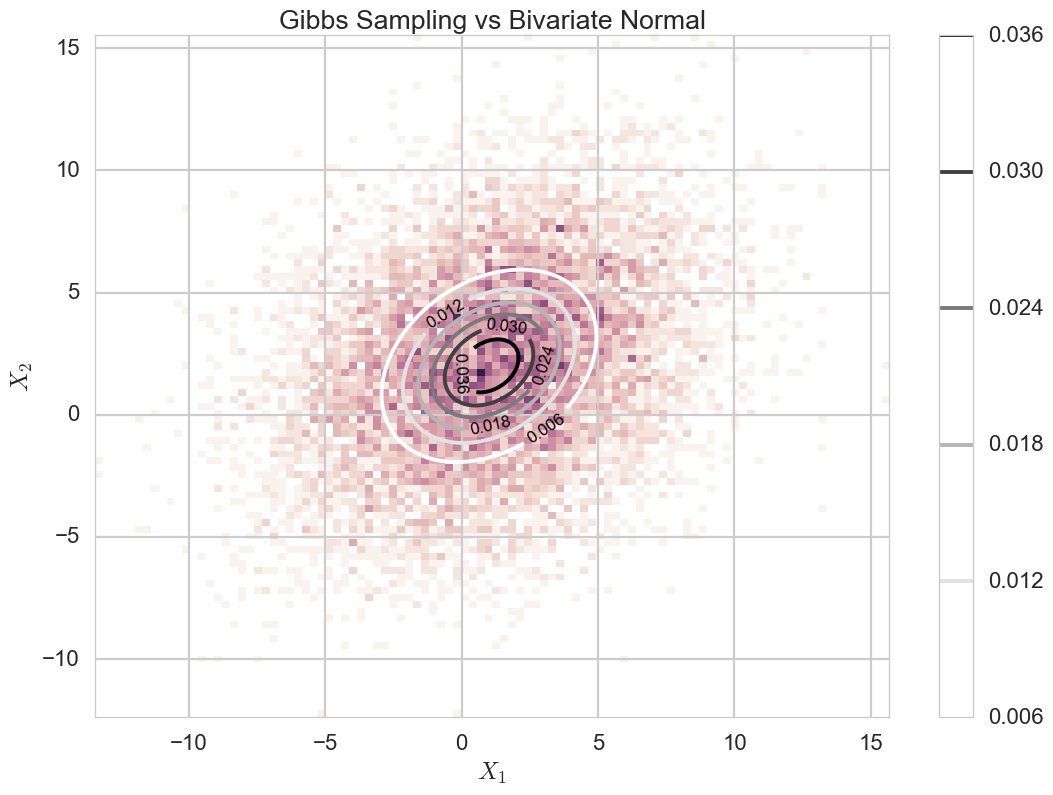

In [5]:
# plot the results with the bivariate normal output

cmap = sns.cubehelix_palette(light=1, as_cmap=True)
plt.hist2d(out[0:,0],out[0:,1], normed=True, bins=100, cmap=cmap)
cp = plt.contour(xx,yy,zz)
plt.clabel(cp, inline=1, fontsize=12, colors=('k'))
plt.xlabel('$X_1$')
plt.ylabel('$X_2$')
plt.title('Gibbs Sampling vs Bivariate Normal')
plt.colorbar(cp)
plt.show()

# Analyze the Autocorrelation

In [6]:
def corrplot(trace, maxlags=50):
    plt.figure(figsize=(10,3))
    plt.acorr(trace-np.mean(trace),  normed=True, maxlags=maxlags);
    plt.xlim([0, maxlags])

<b>All samples

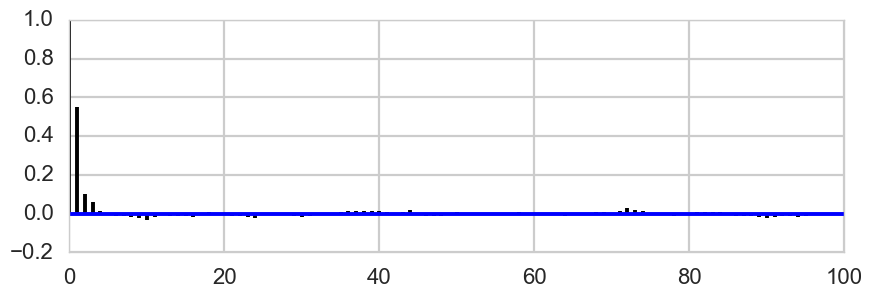

In [7]:
corrplot(out[0:,0], 100)

<b>Samples with burn-in of 1000

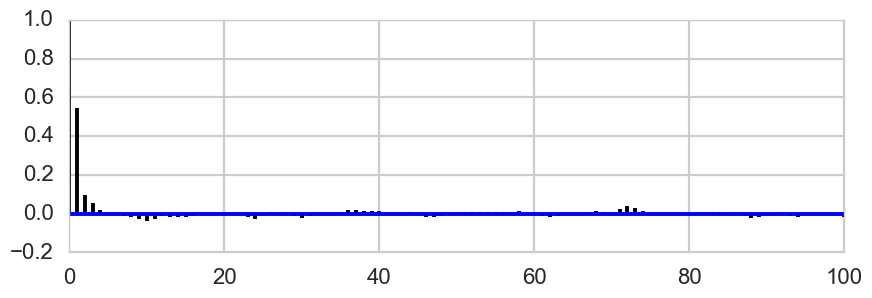

In [8]:
corrplot(out[1000:,0], 100)

<b>Samples with burn-in of 1000 and thinning parameter of 10

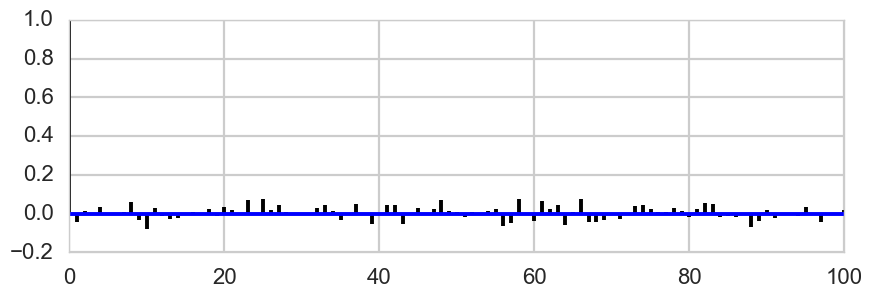

In [9]:
corrplot(out[1000::10,0], 100)

Looking at the above graphs, there is little autocorrelation. This is likely because the bivariate normal distribution for this assignment has little correlation between each step.  We can use some thinning here to remove what little autocorrelation that we see.  Since there is little autocorrelation, it makes sense to use a thinning parameter of 10. 

# Now, execute the gibbs sampler using burn-in of 10% and thinning of 10

In [10]:
# run the gibbs sampler

start = [np.random.normal(),np.random.normal()]
out=gibbs(x1cond, x2cond, 10000, 10, .1, start)

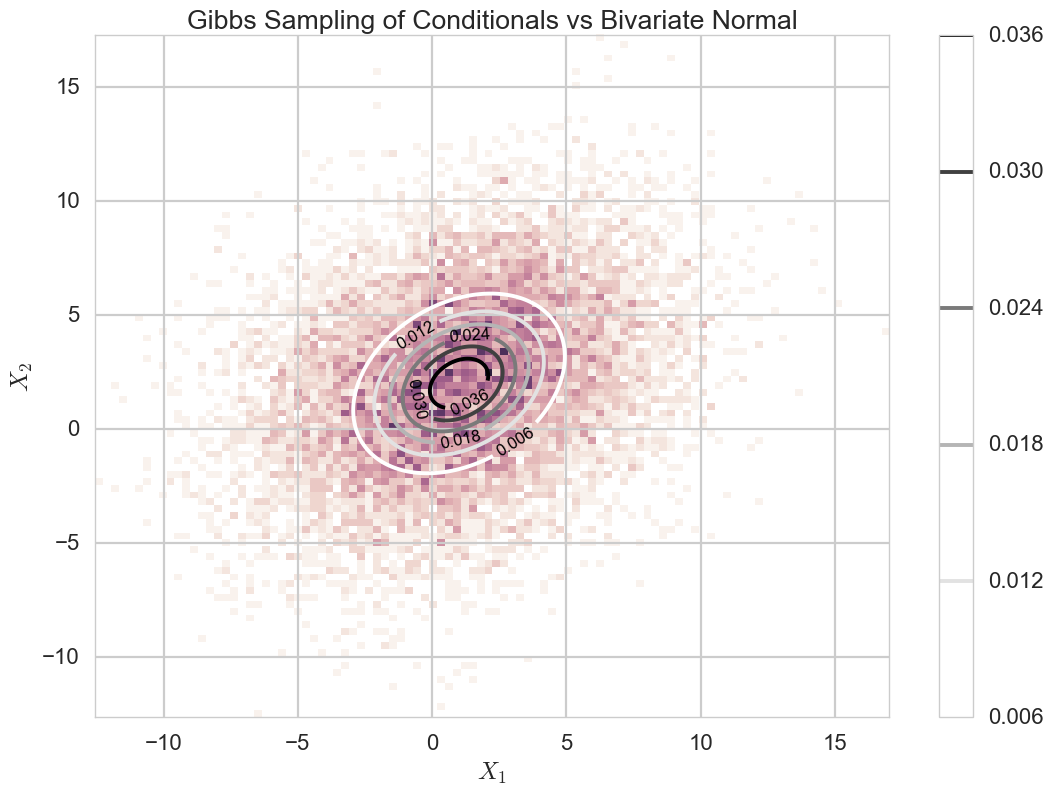

In [11]:
# plot the results with the bivariate normal output

cmap = sns.cubehelix_palette(light=1, as_cmap=True)
plt.hist2d(out[0:,0],out[0:,1], normed=True, bins=100, cmap=cmap)
cp = plt.contour(xx,yy,zz)
plt.clabel(cp, inline=1, fontsize=12, colors=('k'))
plt.xlabel('$X_1$')
plt.ylabel('$X_2$')
plt.title('Gibbs Sampling of Conditionals vs Bivariate Normal')
plt.colorbar(cp)
plt.show()

# How I justify my choice of parameters

We learned earlier that Markov chains may be unstable at first but eventually stabilize after running for a period of time.  Therefore I opted for a 10% burn-in since it seemed prudent to remove up to the first 10% of the sample.  From the PDFs plotted above it does appear that the 10% burn-in did not seem to make a noticeable difference as the two graphs look nearly identical. 

I also noticed some minor autocorrelation and opted for a small thinning parameter of 10 to correct for this.  This substantially decreased the autocorrelation as shown in the third graph. The thinning parameter likely will have to be much bigger had the distribution not been a normal distribution, due to the increased autocorrelation.  

## Problem 2: Bayesian Inference and All That
In the competitive rubber chicken retail market, the success of a company is built on satisfying the exacting standards of a consumer base with refined and discriminating taste. In particular, customer product reviews are all important. But how should we judge the quality of a product based on customer reviews?

On Amazon, the first customer review statistic displayed for a product is the ***average rating***. The following are the main product pages for two competing rubber chicken products, manufactured by Lotus World and Toysmith respectively:


Lotus World |  Toysmith
- |  - 
![alt](lotus1.png) |  ![alt](toysmith1.png)

Clicking on the 'customer review' link on the product pages takes us to a detailed break-down of the reviews. In particular, we can now see the number of times a product is rated a given rating (between 1 and 5 stars).

Lotus World |  Toysmith
- |  - 
![alt](lotus2.png) |  ![alt](toysmith2.png)


In the following, we will ask you to compare these two products using the various rating statistics. Larger versions of the images are available in the data set accompanying this notebook.

Suppose that for each product, we can model the probability of the value each new rating as the following vector:
$$
\theta = [\theta_1, \theta_2, \theta_3, \theta_4, \theta_5]
$$
where $\theta_i$ is the probability that a given customer will give the product $i$ number of stars.


### Part A: Inference

- Suppose you are told that customer opinions are very polarized in the retail world of rubber chickens, that is, most reviews will be 5 stars or 1 stars (with little middle ground). Choose an appropriate Dirichlet prior for $\theta$. Recall that the Dirichlet pdf is given by:
$$
f_{\Theta}(\theta) = \frac{1}{B(\alpha)} \prod_{i=1}^k \theta_i^{\alpha_i - 1}, \quad B(\alpha) = \frac{\prod_{i=1}^k\Gamma(\alpha_i)}{\Gamma\left(\sum_{i=1}^k\alpha_i\right)},
$$
where $\theta_i \in (0, 1)$ and $\sum_{i=1}^k \theta_i = 1$, $\alpha_i > 0 $ for $i = 1, \ldots, k$.

- Write an expression for the posterior pdf, using a using a multinomial model for observed ratings. Recall that the multinomial pdf is given by:
$$
f_{\mathbf{X}\vert  \Theta}(\mathbf{x}) = \frac{n!}{x_1! \ldots x_k!} \theta_1^{x_1} \ldots \theta_k^{x_k}
$$
where $n$ is the total number of trials, $\theta_i$ is the probability of event $i$ and $\sum_i \theta_i = 1$, and $x_i$ is count of outcome $i$ and $\sum_i x_i = n$. 

  **Note:** The data you will need in order to define the likelihood function should be read off the image files included in the dataset.
  

- Sample 1,000 values of $\theta$ from the *posterior distribution*.
 
- Sample 1,000 values of $x$ from the *posterior predictive distribution*.

# 2A Part 1 - Choose an appropriate Dirichlet prior for  θ

We are told that customer opinions are very polarized with mostly 5 stars and 1 star ratings.  To account for this, I set the prior to $\theta = (40,8,4,8,40)$ to weigh the the first and last elements more heavily.  Then I drew 1000 samples from the new distribution and plot them to evaluate the prior. 


# Visualize samples from Dirichlet Prior to verify our choice

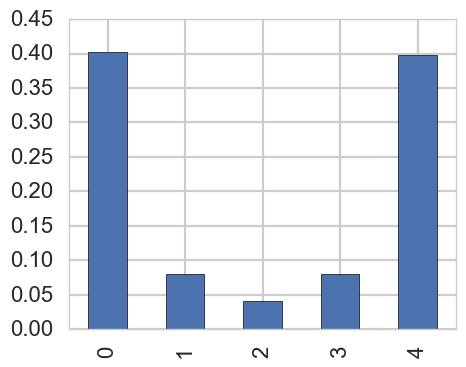

In [12]:
import pandas as pd

DPrior = np.array([40,8,4,8,40])
ThetaPrior = sps.dirichlet(alpha=DPrior)

# create a pandas Series and plot the average of 1k draws
pd.Series(ThetaPrior.rvs(size=1000).mean(axis=0)).plot(kind='bar', figsize=(5, 4))

# 2A Part 2 - Write an expression for the posterior pdf, using a multinomial model for observed ratings.

Each new observation is drawn from a new Dirichlet distribution with the parameter specifeid above and new data points incorporated.  The prior is added to the observed data, which is then used to set the parameters used in sampling from posteriors.  

I calculate the posterior pdf as follows: 

$$
\begin{aligned}
f_{\Theta}(\theta_1, \dots, \theta_k | D) \propto f(\theta, D) \\
& = f(\theta_1, \dots, \theta_k | \alpha_1, \dots, \alpha_k)\Pi_{\mathbf{x}_i \in D}f(\mathbf{x}_i | \theta_1, \dots, \theta_k) \\
&\propto \Pi_{j=1}^k \theta_j^{\alpha_j - 1} \Pi_{D} \Pi_{j=1}^k \theta_j^{x_{ji}} \\
&= \Pi_{j=1}^k \theta_j^{\alpha_j - 1 + \sum_i x_{ji}}
\end{aligned}
$$

Therefore $f_{\Theta}(\theta | D) = Dir(\alpha_1', \alpha_2', \dots, \alpha_k')$ 

where $\alpha_j' = \alpha_j + \sum_i x_{ji}$. 

(each new observation is added to the Dirichlet distribution)

In [13]:
observedForLotusworld = np.array([round(167*i) for i in [.06,.04,.06,.17,.67]])
thetaLotusworld = DPrior+observedForLotusworld

observedForToysmith = np.array([round(410*i) for i in [.14,.08,.07,.11,.60]])
thetaToysmith= DPrior+observedForToysmith

print ("Thetas for our products:")
print("Lotus World", thetaLotusworld)
print("Toysmith", thetaToysmith)

Thetas for our products:
Lotus World [ 50  15  14  36 152]
Toysmith [ 97  41  33  53 286]


# 2A Part 3 - Sample 1,000 values of $\theta$ from the *posterior distribution*.

In [14]:
# get n samples from the Dirichlet distribution using theta as the parameter
def posterior(theta, n=1000):
    return np.random.dirichlet(theta, n) 

# sample from the posterior dist. and create the visualization.
def plot_posterior(theta, title="", dataset=""):
    # get the samples from the posterior distribution using the provided theta
    samps = posterior(theta,n=1000)
    
    # for each sample, plot on the histogram
    for i,star_rank in enumerate(samps.T):
        plt.plot(star_rank.T,label="{2}{0}-Star (Mean:{1:.3f})".format(i+1,star_rank.mean(),dataset))
        plt.ylabel("Sample Size")
        plt.xlabel("Star Rating Probability")
        plt.title(title)
        plt.legend(ncol=2)

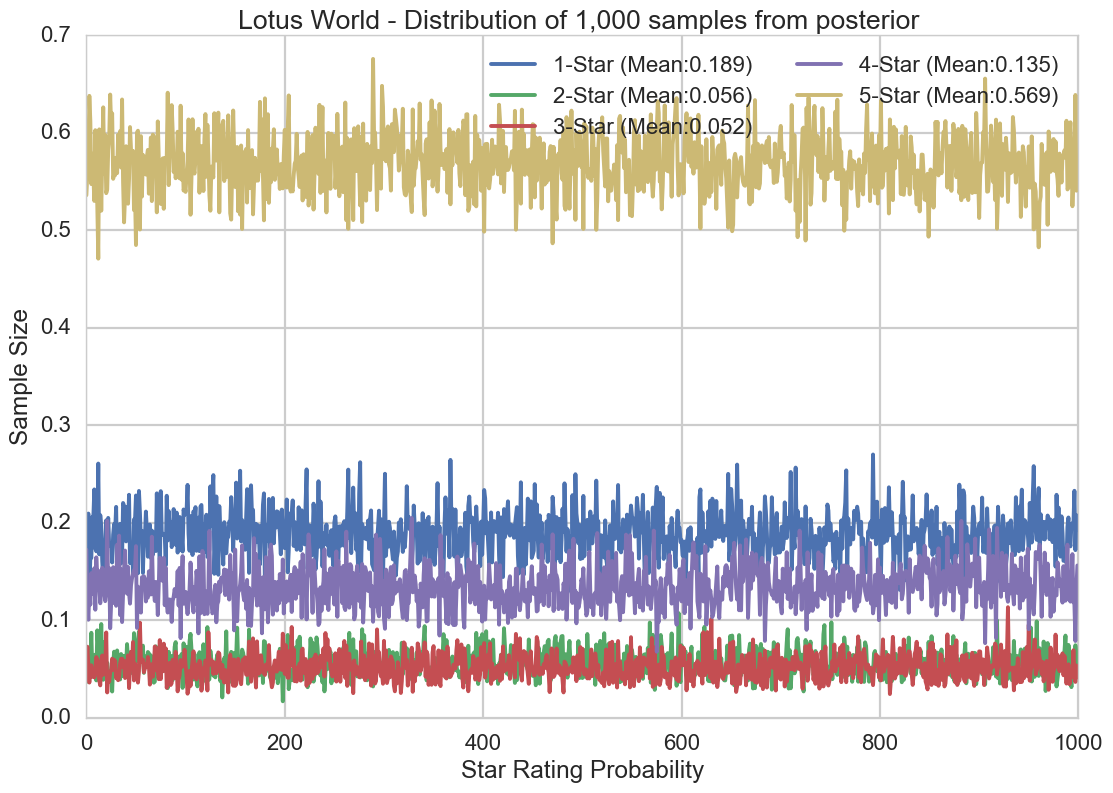

In [15]:
plot_posterior(thetaLotusworld,title="Lotus World - Distribution of 1,000 samples from posterior ")

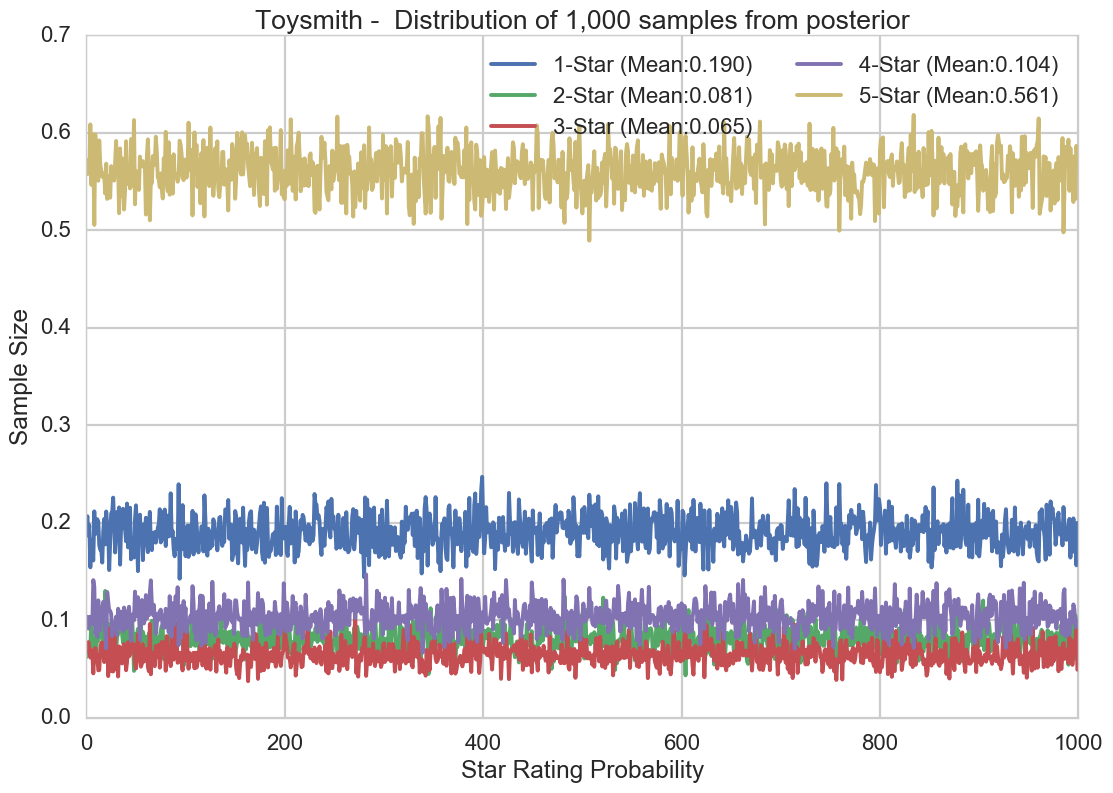

In [16]:
plot_posterior(thetaToysmith,title= "Toysmith -  Distribution of 1,000 samples from posterior")

I first drew from the Dirichlet for a sample of probabilities, which are then placed into a multinomial distribution.  I then drew from this multinomial distribution to count the star ratings.  This sampling tells us that the samples are clustering around the weight as defined by the theta values, of each of the star ratings.  

# 2A Part 4 - Sample 1,000 values of $x$ from the *posterior predictive distribution*.

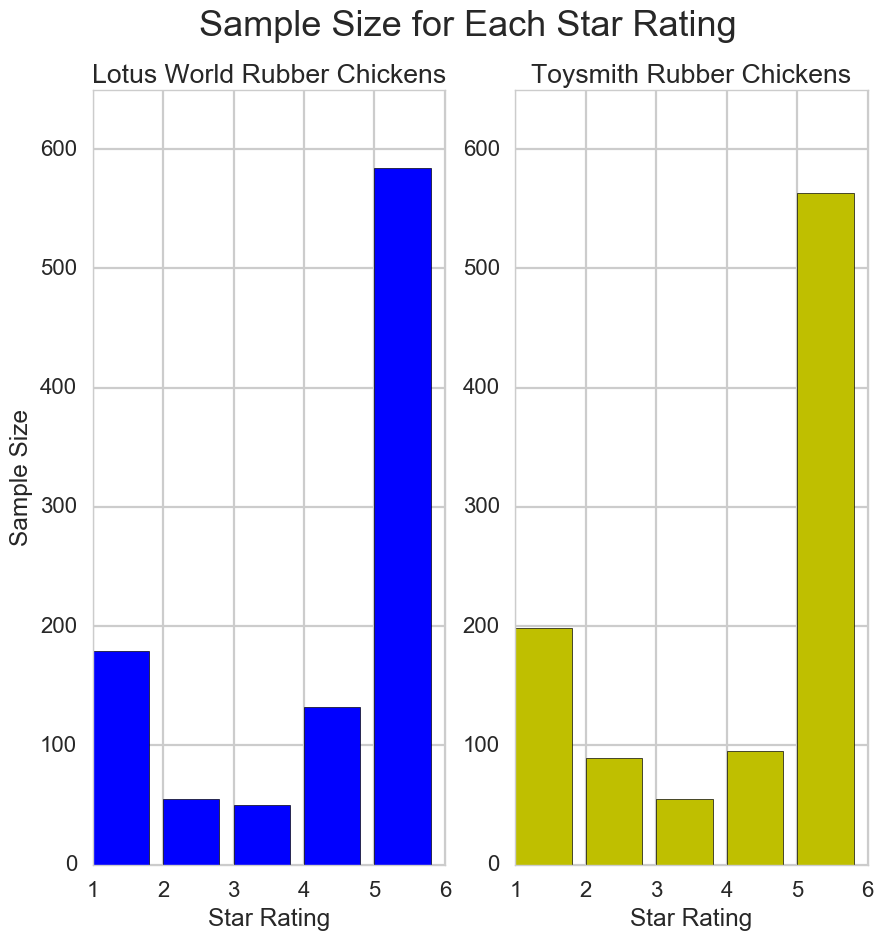

In [17]:
# get the sum of samples from the Dirichlet distribution
def post_predictive(theta, n1=1000,n2=1):
    samps = np.array([np.random.multinomial(n2,s) for s in posterior(theta, n1)])
    return samps.sum(axis=0)

# sample 1,000 values total samples and get back the sum by each star rating
samplesLotusworld = post_predictive(thetaLotusworld)
samplesToysmith = post_predictive(thetaToysmith)

fig = plt.figure(figsize=(10, 10))
x = range(1,6)

ax1 = fig.add_subplot(121)
ax1 = plt.bar(x,samplesLotusworld, color='b')
plt.xlabel('Star Rating')
plt.ylabel('Sample Size')
plt.title("Lotus World Rubber Chickens")
plt.ylim([0,650])
    
ax2 = fig.add_subplot(122)
ax2 = plt.bar(x,samplesToysmith, color='y')
plt.xlabel('Star Rating')
plt.title("Toysmith Rubber Chickens")
plt.ylim([0,650])
plt.suptitle('Sample Size for Each Star Rating', fontsize=26)
plt.show()

### Part B: Ranking

- Name at least two major potential problems with using only the average customer ratings to compare products.

  (**Hint:** if product 1 has a higher average rating than product 2, can we conclude that product 1 is better liked? If product 1 and product 2 have the same average rating, can we conclude that they are equally good?)
  

- Using the samples from your *posterior distribution*, determine which rubber chicken product is superior. Justify your conclusion with sample statistics.

- Using the samples from your *posterior predictive distribution*, determine which rubber chicken product is superior. Justify your conclusion with sample statistics.

- Finally, which rubber chicken product is superior?

  (**Note:** we're not looking for "the correct answer" here, any sound decision based on a statistically correct interpretation of your model will be fine)

# 2B Part 1 - Name at least two major potential problems with using only the average customer ratings to compare products.

1)  Using only the averages, we may overlook important information such as the distribution of the star ratings. For example, one product may be strongly liked and disliked by many but have the same average rating as the product that received overall mediocre reviews.  

2) The average does not take into consideration of the total number of reviews for each product. Two products with identical average may differ vastly in the number of reviews (for example one may have 10 reviews while the other has 1,000 reviews).  Simply looking at the average ignores the fact that the product with more reviews also received a larger number of positive ratings.


# 1B Part 2 - Using the samples from your *posterior distribution*, determine which rubber chicken product is superior. Justify your conclusion with sample statistics.

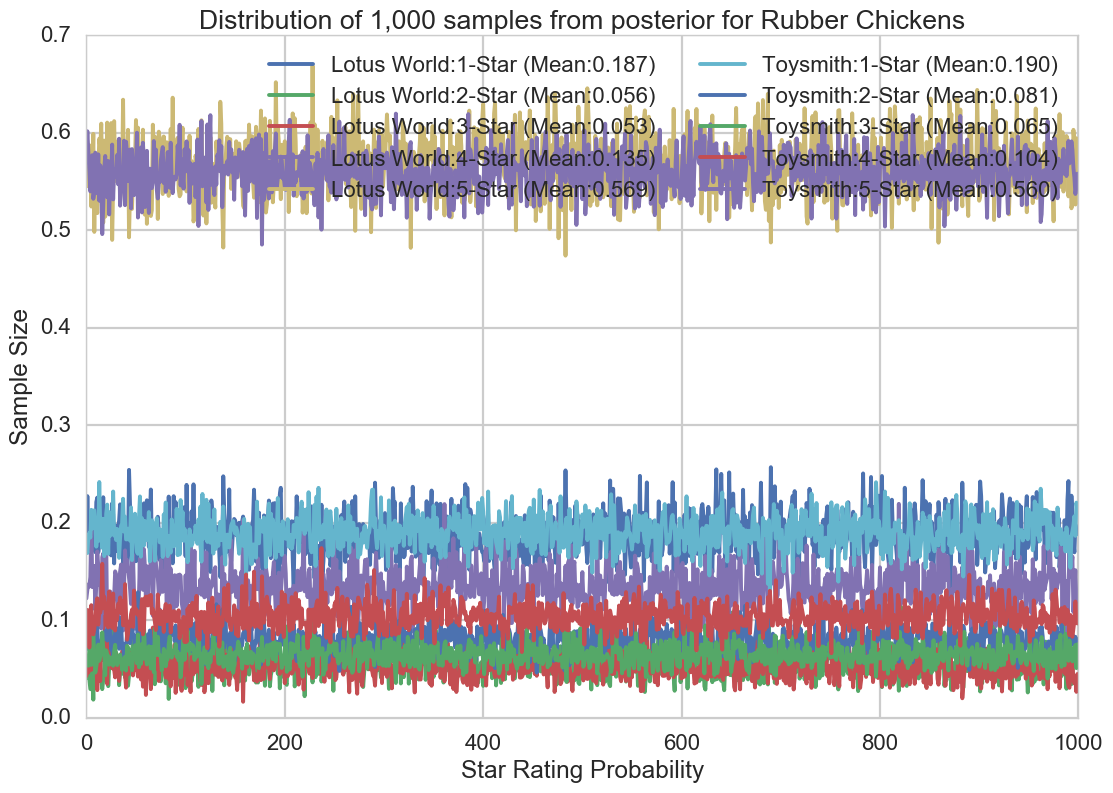

In [18]:
plot_posterior(thetaLotusworld,title="",dataset='Lotus World:')
plot_posterior(thetaToysmith,title="Distribution of 1,000 samples from posterior for Rubber Chickens",dataset='Toysmith:')

The above graph shows that Lotus World chickens are more likely to produce 5 and 4 star ratings compared to Toysmith chickens.  In contrast, Toysmith chickens produce a large amount of 1 and 5 star ratings.  Both Toysmith and Lotus World chickens have polarized ratings, but Toysmith trends higher for the 1 star ratings.

# 2B Part 3 - Using the samples from your *posterior predictive distribution*, determine which rubber chicken product is superior. Justify your conclusion with sample statistics.

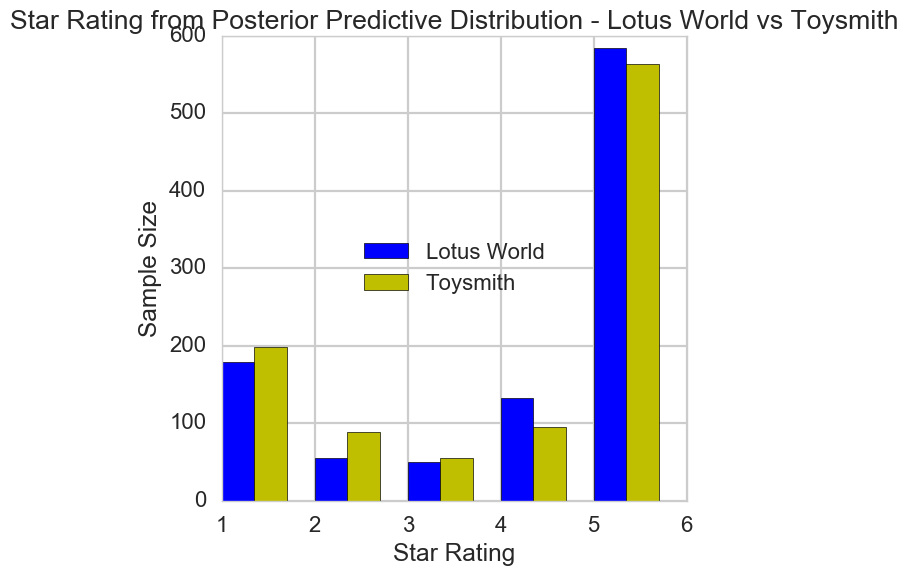

,LotusWorld,Toysmith
count,1000.000000,1000.000000
mean,3.887000,3.736000
std,1.566744,1.639815
min,1.000000,1.000000
25%,3.000000,2.000000
50%,5.000000,5.000000
75%,5.000000,5.000000
max,5.000000,5.000000


In [19]:
# width for barchart bars
width = .35

fig = plt.figure(figsize=(6, 6))
x = np.arange(1,6)

plt.bar(x,samplesLotusworld,width=width,label="Lotus World",color=['b'] )
plt.bar(x+width,samplesToysmith,width=width,label="Toysmith",color=['y'])
plt.xlabel('Star Rating')
plt.ylabel('Sample Size')
plt.legend(loc="center")
plt.title("Star Rating from Posterior Predictive Distribution - Lotus World vs Toysmith")
plt.show()

samplesProcessed = []
for i,r in enumerate(samplesLotusworld):
    samplesProcessed.extend([i + 1]*r)

sampleProcessedLotusWorld = np.array(samplesProcessed)

samplesProcessed = []
for i,r in enumerate(samplesToysmith):
    samplesProcessed.extend([i + 1]*r)
    
sampleProcessedToysmith = np.array(samplesProcessed)

sample_stats = pd.DataFrame({'LotusWorld':sampleProcessedLotusWorld,'Toysmith':sampleProcessedToysmith})
sample_stats.describe()

The same overall trend true with the posterior predictive distribution (although less pronounced compared to the posterior distribution).  Both Toysmith and Lotus World have high 1 and 5 star ratings.  Toysmith chickens have a higher 1, 2 and 3 star counts compared to Lotus World.  Whereas Lotus World chickens have a higher 4 and 5 star counts.

The summary table above confirms what was shown in the graph.  Lotus World chickens have a higher average rating and a lower standard deviation (less varied reviews) compared to Toysmith chickens. 


# 2B Part 4 - Finally, which rubber chicken product is superior?

Based on the above analyses I believe the Lotus World rubber chicken is a superior product. 

As shown above Lotus World chickens have a higher average rating, more consistently high reviews (lower std), and more 4-5 star ratings comapred to Toysmith chickens.  However the results could be skewed since Toysmith has 150% more reviews than Lotus World.  
